### Policy Gradients Tutorial - REINFORCE 

Code Source: https://github.com/pytorch/examples/tree/master/reinforcement_learning 

Slides PDF: http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-5.pdf 


In [0]:
"""
installing dependencies
"""
!apt-get -qq -y install libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay


In [0]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
import random
from gym import wrappers

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

import matplotlib.animation
import numpy as np
from IPython.display import HTML

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


class Args(object):
  pass

args = Args();
args.seed = 543
args.render = True 
args.log_interval = 10   
args.gamma = 0.99

env = gym.make('CartPole-v1')
env.seed(args.seed)
torch.manual_seed(args.seed)

frames = []

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + args.gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


def main():
    running_reward = 10
    for i_episode in count(1):
        state, ep_reward = env.reset(), 0
        for t in range(1, 10000):  # Don't infinite loop while learning
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            if i_episode==800 or i_episode==1:
                frames.append(env.render(mode = 'rgb_array'))
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode()
        if i_episode % args.log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break

main()

Episode 10	Last reward: 26.00	Average reward: 16.00
Episode 20	Last reward: 16.00	Average reward: 14.85
Episode 30	Last reward: 49.00	Average reward: 20.77
Episode 40	Last reward: 45.00	Average reward: 27.37
Episode 50	Last reward: 44.00	Average reward: 30.80
Episode 60	Last reward: 111.00	Average reward: 42.69
Episode 70	Last reward: 131.00	Average reward: 70.39
Episode 80	Last reward: 87.00	Average reward: 76.68
Episode 90	Last reward: 97.00	Average reward: 96.58
Episode 100	Last reward: 87.00	Average reward: 95.25
Episode 110	Last reward: 355.00	Average reward: 111.75
Episode 120	Last reward: 110.00	Average reward: 120.82
Episode 130	Last reward: 106.00	Average reward: 140.40
Episode 140	Last reward: 158.00	Average reward: 139.32
Episode 150	Last reward: 65.00	Average reward: 149.50
Episode 160	Last reward: 116.00	Average reward: 150.58
Episode 170	Last reward: 207.00	Average reward: 191.71
Episode 180	Last reward: 88.00	Average reward: 171.54
Episode 190	Last reward: 118.00	Average

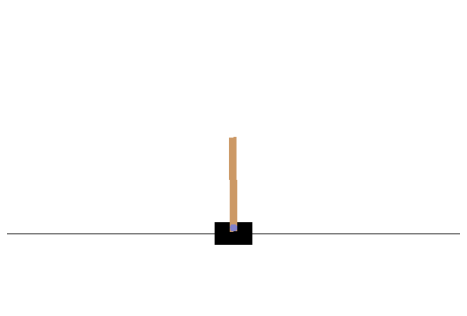

In [0]:
deep_frames = frames
plt.figure(figsize=(deep_frames[0].shape[1] / 72.0, deep_frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(deep_frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(deep_frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(deep_frames), interval = 50)
HTML(ani.to_jshtml())